In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [21]:
PROCESSED_DIR = "../data/processed"
TICKERS = ["AAPL", "MSFT", "AMZN", "GOOGL", "META"]
RETURNS = f"{PROCESSED_DIR}/returns_matrix.csv"
if not os.path.exists(RETURNS):
    raise FileNotFoundError(f"returns_matrix.csv not found at {RETURNS}")

returns_df = pd.read_csv(RETURNS, parse_dates=["Date"])
returns_df = returns_df.set_index("Date")
print("Loaded returns data:", returns_df.shape)
print(returns_df.head())

Loaded returns data: (2244, 5)
                AAPL      MSFT      AMZN     GOOGL      META
Date                                                        
2015-02-02  0.012251  0.021443  0.027651 -0.010001 -0.012194
2015-02-03  0.000189  0.007717 -0.002527  0.002065  0.005453
2015-02-04  0.007516  0.005750  0.003295 -0.013593  0.003046
2015-02-05  0.007303  0.014466  0.024749  0.007060 -0.000264
2015-02-06 -0.008714 -0.000908  0.001043  0.007620 -0.015192


In [22]:
def sharpe_ratio(daily_returns, risk_free_daily=0.00002):
    excess = daily_returns - risk_free_daily
    mu = excess.mean()
    sigma = excess.std()
    daily = mu / (sigma + 1e-9)
    return daily * np.sqrt(252)

def plot_cumulative_returns(daily_returns, title="Cumulative Return"):
    cum = (1 + daily_returns)
    cum = cum.cumprod()
    plt.plot(cum)
    plt.title(title)
    plt.xlabel("Time (days)")
    plt.ylabel("Cumulative growth of $1")
    plt.grid(True)
    plt.show()

Build regime-based MDP that discretizes the market into Bear (< -1%), Sideways (between -1% and +1%), and Bull (> +1%), such that the index is the equal-weighted average return of assets

In [23]:
def regime_bucket(r):
    if r < -0.01:
        return 0
    elif r > 0.01:
        return 2
    else:
        return 1

# Lag
market_ret = returns_df.mean(axis=1).sort_index()
market_ret_lag = market_ret.shift(1)
regimes_series = market_ret_lag.dropna().apply(regime_bucket)
market_ret = market_ret.loc[regimes_series.index]
regimes = regimes_series.values

state_names = ["Bear", "Sideways", "Bull"]
n_states = 3

Estimate MDP from data (transition and reward matrices)

In [24]:
# Chronological split
idx = market_ret.index
n = len(idx)
split = int(0.8 * n)
train_idx = idx[:split]
test_idx = idx[split:]
print("Train length:", len(train_idx))
print("Test length:", len(test_idx))

# Use only training data to estimate transitions
P_counts = np.zeros((n_states, n_states))
for i in range(len(train_idx) - 1):
    t = train_idx[i]
    t_next = train_idx[i+1]
    s = int(regimes_series.loc[t])
    s_next = int(regimes_series.loc[t_next])
    P_counts[s, s_next] += 1

P_ss = np.zeros_like(P_counts)
for s in range(n_states):
    row = P_counts[s]
    if row.sum() > 0:
        P_ss[s] = row / row.sum()
    else:
        P_ss[s] = np.ones(n_states) / n_states

print("Transition matrix P(s'|s):")
print(pd.DataFrame(P_ss, index=state_names, columns=state_names))

Train length: 1794
Test length: 449
Transition matrix P(s'|s):
              Bear  Sideways      Bull
Bear      0.225694  0.458333  0.315972
Sideways  0.136159  0.658251  0.205591
Bull      0.181818  0.621212  0.196970


In [25]:
# Actions scale exposure to market (half, full, leveraged)
action_names = ["Risk-Off", "Neutral", "Risk-On"]
n_actions = 3
action_scalers = {
    0: 0.5,
    1: 1.0,
    2: 1.5
}

R = np.zeros((n_states, n_actions))

# Transaction cost
tc = 0.001
for s in range(n_states):
    mask = (regimes_series.loc[train_idx] == s)
    state_returns = market_ret.loc[train_idx][mask].values
    if len(state_returns) == 0:
        continue
    mean_ret = state_returns.mean()
    for a in range(n_actions):
        exposure = action_scalers[a]
        # Distance from baseline exposure
        cost = tc * abs(exposure - 1.0)
        R[s, a] = exposure * mean_ret - cost

In [26]:
# Build full transition model P[s,a,s']
P = np.zeros((n_states, n_actions, n_states))
for s in range(n_states):
    for a in range(n_actions):
        P[s, a, :] = P_ss[s, :]

Value iteration

In [27]:
def value_iteration(P, R, gamma=0.99, tol=1e-6, max_iter=1000):
    S, A = R.shape
    V = np.zeros(S)

    for it in range(max_iter):
        V_new = np.zeros_like(V)
        for s in range(S):
            q_vals = []
            for a in range(A):
                q = R[s, a] + gamma * np.dot(P[s, a], V)
                q_vals.append(q)
            V_new[s] = max(q_vals)

        if np.max(np.abs(V_new - V)) < tol:
            print(f"Converged in {it} iterations")
            V = V_new
            break

        V = V_new

    # Extract greedy policy
    policy = np.zeros(S, dtype=int)
    for s in range(S):
        q_vals = []
        for a in range(A):
            q = R[s, a] + gamma * np.dot(P[s, a], V)
            q_vals.append(q)
        policy[s] = np.argmax(q_vals)

    return V, policy

gamma = 0.99
V, pi = value_iteration(P, R, gamma=gamma)

print("Optimal Value Function V*(s):")
for i in range(n_states):
    print(f"  {state_names[i]}: {V[i]:.6f}")

print("Optimal Policy π*(s):")
for i in range(n_states):
    print(f"In state {state_names[i]}, take action '{action_names[pi[i]]}'")

Converged in 698 iterations
Optimal Value Function V*(s):
  Bear: 0.113165
  Sideways: 0.111209
  Bull: 0.109687
Optimal Policy π*(s):
In state Bear, take action 'Risk-On'
In state Sideways, take action 'Risk-On'
In state Bull, take action 'Neutral'


In [28]:
def evaluate_policy_vi(idx):
    test_list = list(idx)

    prev_a = 1
    prev_exp = action_scalers[prev_a]
    out = []

    for i in range(len(test_list) - 1):
        t = test_list[i]
        t_next = test_list[i + 1]

        s = int(regimes_series.loc[t])
        a = int(pi[s])
        exp = action_scalers[a]

        realized = market_ret.loc[t_next]

        turnover = abs(exp - prev_exp)
        cost = tc * turnover

        net_ret = exp * realized - cost
        out.append(net_ret)

        prev_a = a
        prev_exp = exp

    return np.array(out)

Value Iteration Policy Performance
Sharpe: 0.197
Final value: 0.994


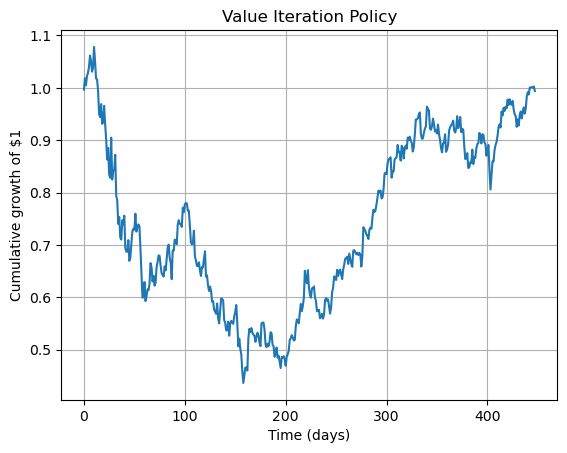

In [29]:
vi_returns = evaluate_policy_vi(test_idx)
vi_returns = pd.Series(vi_returns)

sharpe = sharpe_ratio(vi_returns)
final_value = (1 + vi_returns).cumprod().iloc[-1]

print("Value Iteration Policy Performance")
print(f"Sharpe: {sharpe:.3f}")
print(f"Final value: {final_value:.3f}")

plot_cumulative_returns(vi_returns, title="Value Iteration Policy")

Value Iteration Policy Performance
Sharpe: 0.696
Final value: 5.546


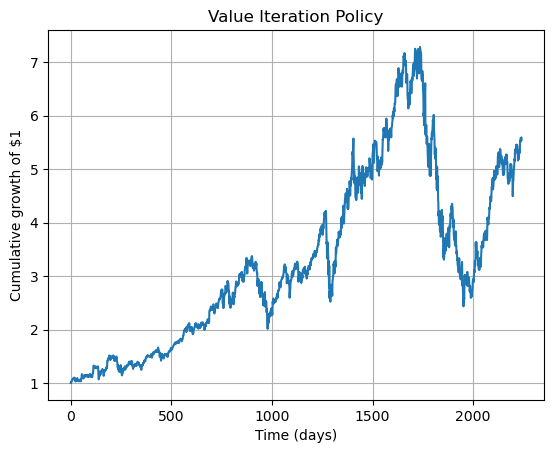

In [30]:
vi_returns = evaluate_policy_vi(idx)
vi_returns = pd.Series(vi_returns)

sharpe = sharpe_ratio(vi_returns)
final_value = (1 + vi_returns).cumprod().iloc[-1]

print("Value Iteration Policy Performance")
print(f"Sharpe: {sharpe:.3f}")
print(f"Final value: {final_value:.3f}")

plot_cumulative_returns(vi_returns, title="Value Iteration Policy")